In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from acfunctions import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import astropy.stats as astat
from solartwins import *
import pickle
from IPython.display import Image, display, HTML
import starspot as ss
import starspot.rotation_tools as rt
from starspot import sigma_clipping
import lightkurve as lk
from lightkurve import search_targetpixelfile, search_lightcurvefile
import math
import exoplanet
import eleanor
from astropy.coordinates import SkyCoord
from tess_kep_funct import *
from tqdm import tqdm
from scipy import misc
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook

WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=False)

# importing tess vs kepler data

In [4]:
tess_kep = pd.read_csv('data_summary.csv')

In [5]:
tess_short = tess_kep[tess_kep.tess_ffi == True]

In [6]:
cat = pd.read_csv('tics_kics_mcq_rot.txt', names=['tic_id', 'kic_id', 'prot'], delim_whitespace=True)

# comparing kepler and tess period calculations from starspot

tic_ids_plot = np.array(cat['tic_id'])[0:61] #TIC IDs for the first 27 stars
#kep_ids_plot = np.array(cat['kic_id'])[0:27] #KIC IDs for the first 27 stars

#tic_ids_plot_2 = np.array(cat['tic_id'])[27:61] #TIC IDs for the next 33 stars
#kep_ids_plot_2 = np.array(cat['kic_id'])[27:61] #KIC IDs for the next 33 stars

#kepler_periods_1 = [] #array of calculated periods from kepler function with ID input
tess_periods_1 = [] #array of calculated periods from tess function with ID input

for index, value in (enumerate(tic_ids_plot)):
    period_tess = eleanor_plots(value,index)
    tess_periods_1.append(period_tess)

    #period_kep = kep_ac(kep_ids_plot[index], index)
    #kepler_periods_1.append(period_kep)

kepler_periods_2 = [] #array of calculated periods from kepler function with ID input
tess_periods_2 = [] #array of calculated periods from tess function with ID input

for index, value in (enumerate(tic_ids_plot_2)):
    period_tess_2 = eleanor_plots(value,index*2)
    tess_periods_2.append(period_tess_2)

    period_kep_2 = kep_ac(kep_ids_plot_2[index], index*2)
    kepler_periods_2.append(period_kep_2)

with open('tess_periods_1.data', 'wb') as filehandle:
    pickle.dump(tess_periods_1, filehandle)
    
#with open('kepler_periods_1.data', 'wb') as filehandle:
    #pickle.dump(kepler_periods_1, filehandle)

with open('tess_periods_2.data', 'wb') as filehandle:
    pickle.dump(tess_periods_2, filehandle)
    
with open('kepler_periods_2.data', 'wb') as filehandle:
    pickle.dump(kepler_periods_2, filehandle)

In [20]:
with open('tess_periods_1.data', 'rb') as filehandle:
    tess_periods_1 = pickle.load(filehandle) 
    
with open('kepler_periods_1.data', 'rb') as filehandle:
    kepler_periods_1 = pickle.load(filehandle) 

with open('tess_periods_2.data', 'rb') as filehandle:
    tess_periods_2 = pickle.load(filehandle) 
    
with open('kepler_periods_2.data', 'rb') as filehandle:
    kepler_periods_2 = pickle.load(filehandle) 

#combining the two sets
tess_periods = np.array(tess_periods_1 + tess_periods_2)
kepler_periods = np.array(kepler_periods_1 + kepler_periods_2)

# period calculation 1 

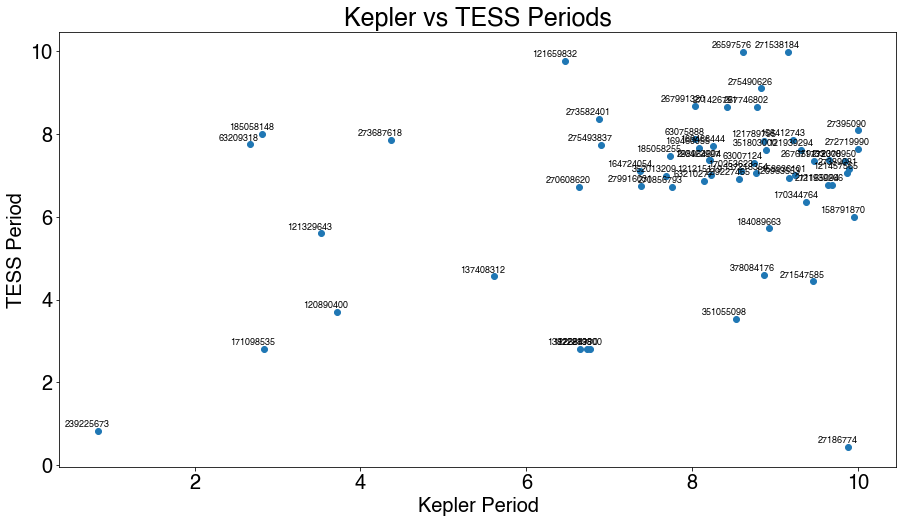

In [31]:
plt.figure(figsize=(15,8))
plt.scatter(kepler_periods, tess_periods)
plt.xlabel('Kepler Period', fontsize = 20)
plt.ylabel('TESS Period', fontsize = 20)
plt.title('Kepler vs TESS Periods', fontsize = 25)

for i, txt in enumerate(np.array(cat['tic_id'])[0:61]):
    plt.annotate(txt, xy=(kepler_periods[i], tess_periods[i]), xytext=(-11,2), textcoords='offset points', ha='center', va='bottom', fontsize= 9)

plt.show()

In [32]:
output_notebook() 

Loading BokehJS ...

In [36]:
x =  kepler_periods
y = tess_periods

source = ColumnDataSource(data=dict(
    x =  kepler_periods,
    y = tess_periods, 
    kep = (cat['kic_id'])[0:61],
    tess = (cat['tic_id'])[0:61]))

x2 = [i*2 for i in x]
x_half = [float(i)*0.5 for i in x]

kepvstess = figure(
   tools="pan,box_zoom,reset,save,hover",
   y_range=[2, 10], title="Kepler vs TESS Periods",
   x_axis_label='Kepler Period', y_axis_label='TESS Period', plot_width=900)

kepvstess.line(x, x, name = "y=x", color = 'pink', line_dash="4 4", legend = "y=x", line_width = 2)
kepvstess.circle('x', 'y', source = source, color="navy", line_color=None)
kepvstess.line(x, x2, legend="y=2x", line_width=1, color = 'gold', line_dash="dotted")
kepvstess.line(x, x_half, legend="y=0.5*x", line_width=1, color = 'lavender', line_dash="dotted")

kepvstess.hover.tooltips = [
    ("index", "$index"), 
    ("(x,y)", "($x, $y)"), 
    ("TIC ID", "@tess"), 
    ("KIC ID", "@kep")] 

show(kepvstess)

# adding in mcquillan periods to compare 

In [10]:
headers = 'TIC ID', 'KIC ID', 'McQ Periods'  

with open("tics_kics_mcq_rot.txt") as file:
    rot_table = [line.split() for line in file.read().splitlines()]

widths = [max(len(value) for value in col)
for col in zip(*(rot_table + [headers]))]

formatting = '{:{widths[0]}}  {:{widths[1]}}  {:{widths[2]}}'
formatting.format(*headers, widths=widths)
for tics_kics_mcq in rot_table:
    formatting.format(*tics_kics_mcq, widths=widths)

In [11]:
# converting txt file data to arrays
tic_ids = []
kic_ids = []
mcq_periods = []

for index, row in enumerate(rot_table):
    tic_ids.append(int(rot_table[index][0]))
    kic_ids.append(int(rot_table[index][1]))
    mcq_periods.append(float(rot_table[index][2]))

In [12]:
# selecting shortest periods only (<13 days, half a tess cycle)
short_periods = []
tics_short_periods = []
kics_short_periods = []

for index, period in enumerate(mcq_periods):
    if period < 13: 
        short_periods.append(period)
        tics_short_periods.append(tic_ids[index])
        kics_short_periods.append(kic_ids[index])

# finding the kepler & tess periods for the shortest found mcq periods

In [13]:
#kep_period = []
tess_period = []

for index, value in (enumerate(tics_short_periods[0:61])):
    #period_kep = kep_ac(kics_short_periods[index], num)
    #kep_period.append(period_kep)
    
    period_tess = eleanor_plots(value, index)
    tess_period.append(period_tess)

0
No eleanor postcard has been made for your target (yet). Using TessCut instead.



100%|██████████| 1197/1197 [00:24<00:00, 48.20it/s]

100%|██████████| 1000/1000 [00:01<00:00, 956.34it/s][A


275493837
1
No eleanor postcard has been made for your target (yet). Using TessCut instead.



100%|██████████| 1241/1241 [00:21<00:00, 56.48it/s]

100%|██████████| 1000/1000 [00:01<00:00, 983.15it/s][A


fitting to a limited range
121789795
2
No eleanor postcard has been made for your target (yet). Using TessCut instead.



100%|██████████| 1241/1241 [00:28<00:00, 43.37it/s]

100%|██████████| 1000/1000 [00:01<00:00, 923.53it/s][A


171098535
3
No eleanor postcard has been made for your target (yet). Using TessCut instead.



100%|██████████| 1241/1241 [00:26<00:00, 47.70it/s]

100%|██████████| 1000/1000 [00:00<00:00, 1019.95it/s][A


fitting to a limited range
121457565
4
No eleanor postcard has been made for your target (yet). Using TessCut instead.



100%|██████████| 1241/1241 [00:31<00:00, 39.55it/s]

100%|██████████| 1000/1000 [00:01<00:00, 667.24it/s][A


fitting to a limited range
137218354
5
No eleanor postcard has been made for your target (yet). Using TessCut instead.



100%|██████████| 1241/1241 [00:27<00:00, 45.47it/s]

100%|██████████| 1000/1000 [00:01<00:00, 768.76it/s][A


fitting to a limited range
121659832
6
No eleanor postcard has been made for your target (yet). Using TessCut instead.



100%|██████████| 1241/1241 [00:26<00:00, 46.41it/s]

100%|██████████| 1000/1000 [00:01<00:00, 860.03it/s][A


138728898
7
No eleanor postcard has been made for your target (yet). Using TessCut instead.



100%|██████████| 1197/1197 [00:23<00:00, 51.86it/s]

100%|██████████| 1000/1000 [00:00<00:00, 1013.57it/s][A


63209318
8
No eleanor postcard has been made for your target (yet). Using TessCut instead.



100%|██████████| 1197/1197 [00:23<00:00, 51.50it/s]

100%|██████████| 1000/1000 [00:00<00:00, 1021.81it/s][A


185058148
9
No eleanor postcard has been made for your target (yet). Using TessCut instead.



100%|██████████| 1197/1197 [00:20<00:00, 58.62it/s]

100%|██████████| 1000/1000 [00:01<00:00, 925.44it/s][A


271426791
10
No eleanor postcard has been made for your target (yet). Using TessCut instead.



100%|██████████| 1197/1197 [00:26<00:00, 44.94it/s]

100%|██████████| 1000/1000 [00:01<00:00, 998.21it/s]


272719990
11
No eleanor postcard has been made for your target (yet). Using TessCut instead.



100%|██████████| 1197/1197 [00:26<00:00, 44.55it/s]

100%|██████████| 1000/1000 [00:01<00:00, 667.82it/s][A


239227465
12
No eleanor postcard has been made for your target (yet). Using TessCut instead.



100%|██████████| 1197/1197 [00:33<00:00, 36.05it/s]

100%|██████████| 1000/1000 [00:01<00:00, 635.03it/s][A


271538184
13
No eleanor postcard has been made for your target (yet). Using TessCut instead.



100%|██████████| 1197/1197 [00:33<00:00, 35.26it/s]

100%|██████████| 1000/1000 [00:01<00:00, 913.44it/s][A


170344764
14
No eleanor postcard has been made for your target (yet). Using TessCut instead.



100%|██████████| 1241/1241 [00:29<00:00, 41.44it/s]

100%|██████████| 1000/1000 [00:01<00:00, 847.67it/s][A


fitting to a limited range
351055098
15
No eleanor postcard has been made for your target (yet). Using TessCut instead.



 58%|█████▊    | 722/1241 [00:54<01:38,  5.26it/s]


 83%|████████▎ | 1024/1241 [01:46<00:34,  6.32it/s]


100%|██████████| 1241/1241 [02:20<00:00,  8.82it/s]

100%|██████████| 1000/1000 [00:01<00:00, 694.76it/s][A


120890400
16
No eleanor postcard has been made for your target (yet). Using TessCut instead.



100%|██████████| 1241/1241 [00:26<00:00, 46.83it/s]

100%|██████████| 1000/1000 [00:01<00:00, 918.96it/s][A


137408312
17
No eleanor postcard has been made for your target (yet). Using TessCut instead.



100%|██████████| 1197/1197 [00:25<00:00, 47.43it/s]

100%|██████████| 1000/1000 [00:01<00:00, 929.38it/s][A


267671733
18
No eleanor postcard has been made for your target (yet). Using TessCut instead.



100%|██████████| 1197/1197 [00:24<00:00, 48.78it/s]

100%|██████████| 1000/1000 [00:01<00:00, 950.41it/s][A


158936101
19
No eleanor postcard has been made for your target (yet). Using TessCut instead.



100%|██████████| 1197/1197 [00:30<00:00, 39.19it/s]

100%|██████████| 1000/1000 [00:01<00:00, 907.42it/s][A


27389081
20
No eleanor postcard has been made for your target (yet). Using TessCut instead.



100%|██████████| 1197/1197 [00:25<00:00, 46.47it/s]

100%|██████████| 1000/1000 [00:01<00:00, 873.85it/s][A


360022896
21
No eleanor postcard has been made for your target (yet). Using TessCut instead.



100%|██████████| 1197/1197 [00:35<00:00, 33.38it/s]

100%|██████████| 1000/1000 [00:01<00:00, 922.06it/s][A


fitting to a limited range
184090759
22
No eleanor postcard has been made for your target (yet). Using TessCut instead.



100%|██████████| 1197/1197 [00:23<00:00, 50.17it/s]

100%|██████████| 1000/1000 [00:01<00:00, 940.23it/s][A


272596433
23
No eleanor postcard has been made for your target (yet). Using TessCut instead.



100%|██████████| 1197/1197 [00:35<00:00, 33.85it/s]

100%|██████████| 1000/1000 [00:01<00:00, 807.23it/s][A


270701679
24
No eleanor postcard has been made for your target (yet). Using TessCut instead.



100%|██████████| 1197/1197 [00:23<00:00, 50.23it/s]

100%|██████████| 1000/1000 [00:01<00:00, 952.77it/s][A


63368484
25
No eleanor postcard has been made for your target (yet). Using TessCut instead.



100%|██████████| 1197/1197 [00:32<00:00, 37.13it/s]

100%|██████████| 1000/1000 [00:01<00:00, 907.80it/s][A


271538204
26
No eleanor postcard has been made for your target (yet). Using TessCut instead.



100%|██████████| 1197/1197 [00:31<00:00, 37.60it/s]

100%|██████████| 1000/1000 [00:02<00:00, 422.84it/s][A


fitting to a limited range
273048382
27
No eleanor postcard has been made for your target (yet). Using TessCut instead.



100%|██████████| 1197/1197 [00:30<00:00, 39.45it/s]

100%|██████████| 1000/1000 [00:01<00:00, 825.54it/s][A


159721038
28
No eleanor postcard has been made for your target (yet). Using TessCut instead.



100%|██████████| 1197/1197 [00:22<00:00, 53.20it/s]

100%|██████████| 1000/1000 [00:01<00:00, 904.16it/s][A


63291536
29
No eleanor postcard has been made for your target (yet). Using TessCut instead.



100%|██████████| 1197/1197 [00:27<00:00, 43.29it/s]

100%|██████████| 1000/1000 [00:01<00:00, 868.95it/s][A


271959015
30
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...



100%|██████████| 1197/1197 [00:23<00:00, 50.54it/s]

100%|██████████| 1000/1000 [00:01<00:00, 897.19it/s][A


270705471
31
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...



100%|██████████| 1197/1197 [00:25<00:00, 47.58it/s]

100%|██████████| 1000/1000 [00:01<00:00, 937.48it/s][A


271882234
32
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...



100%|██████████| 1197/1197 [00:26<00:00, 44.71it/s]

100%|██████████| 1000/1000 [00:01<00:00, 713.71it/s][A


171097828
33
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...



100%|██████████| 1197/1197 [00:39<00:00, 30.44it/s]

100%|██████████| 1000/1000 [00:01<00:00, 913.58it/s][A


273684707
34
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...



100%|██████████| 1197/1197 [00:25<00:00, 46.92it/s]

100%|██████████| 1000/1000 [00:01<00:00, 926.90it/s][A


fitting to a limited range
26749760
35
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...



 27%|██▋       | 323/1197 [00:43<01:42,  8.50it/s]


 52%|█████▏    | 625/1197 [01:26<01:13,  7.78it/s]


 78%|███████▊  | 929/1197 [02:15<00:34,  7.72it/s]


100%|██████████| 1197/1197 [02:53<00:00,  6.88it/s]

100%|██████████| 1000/1000 [00:01<00:00, 910.85it/s][A


fitting to a limited range
299218911
36
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...



100%|██████████| 1241/1241 [00:30<00:00, 40.50it/s]

100%|██████████| 1000/1000 [00:01<00:00, 786.42it/s][A


137317669
37
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...



 27%|██▋       | 328/1197 [00:42<01:53,  7.67it/s]


100%|██████████| 1197/1197 [01:01<00:00, 19.44it/s]

100%|██████████| 1000/1000 [00:01<00:00, 926.49it/s][A


416634984
38
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...



100%|██████████| 1241/1241 [00:27<00:00, 45.76it/s]

100%|██████████| 1000/1000 [00:01<00:00, 892.00it/s][A


299218360
39
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...



100%|██████████| 1197/1197 [00:29<00:00, 39.98it/s]

100%|██████████| 1000/1000 [00:01<00:00, 948.92it/s][A


fitting to a limited range
270863295
40
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...



100%|██████████| 1241/1241 [00:26<00:00, 47.18it/s]

100%|██████████| 1000/1000 [00:01<00:00, 863.30it/s][A


164652676
41
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...



 27%|██▋       | 324/1197 [00:43<01:44,  8.39it/s]


 52%|█████▏    | 626/1197 [01:25<01:39,  5.74it/s]


 78%|███████▊  | 928/1197 [02:17<00:58,  4.56it/s]


100%|██████████| 1197/1197 [03:08<00:00,  6.37it/s]

100%|██████████| 1000/1000 [00:01<00:00, 926.24it/s][A


fitting to a limited range
27396955
42
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...



100%|██████████| 1197/1197 [00:30<00:00, 39.07it/s]

100%|██████████| 1000/1000 [00:01<00:00, 892.24it/s][A


272598447
43
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...



100%|██████████| 1197/1197 [00:29<00:00, 40.11it/s]

100%|██████████| 1000/1000 [00:01<00:00, 835.74it/s][A


159650508
44
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...



100%|██████████| 1197/1197 [00:37<00:00, 31.70it/s]

100%|██████████| 1000/1000 [00:01<00:00, 920.25it/s][A


159761678
45
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...



100%|██████████| 1197/1197 [00:27<00:00, 42.80it/s]

100%|██████████| 1000/1000 [00:01<00:00, 719.65it/s][A


268606389
46
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...



100%|██████████| 1197/1197 [00:25<00:00, 47.82it/s]

100%|██████████| 1000/1000 [00:01<00:00, 909.88it/s][A


424865046
47
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...



100%|██████████| 1241/1241 [00:29<00:00, 41.39it/s]

100%|██████████| 1000/1000 [00:01<00:00, 884.89it/s][A


159717504
48
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...



100%|██████████| 1241/1241 [00:30<00:00, 40.45it/s]

100%|██████████| 1000/1000 [00:01<00:00, 876.45it/s][A


121276464
49
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...



100%|██████████| 1197/1197 [00:30<00:00, 39.69it/s]

100%|██████████| 1000/1000 [00:01<00:00, 938.26it/s][A


268607996
50
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...



100%|██████████| 1197/1197 [00:24<00:00, 48.34it/s]

100%|██████████| 1000/1000 [00:01<00:00, 869.23it/s][A


270696609
51
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...



100%|██████████| 1197/1197 [00:27<00:00, 44.28it/s]

100%|██████████| 1000/1000 [00:01<00:00, 948.14it/s][A


268380764
52
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...



100%|██████████| 1241/1241 [00:30<00:00, 41.09it/s]

100%|██████████| 1000/1000 [00:01<00:00, 828.50it/s][A


137403018
53
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...



100%|██████████| 1241/1241 [00:32<00:00, 38.46it/s]

100%|██████████| 1000/1000 [00:01<00:00, 852.61it/s][A


184087631
54
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...



100%|██████████| 1197/1197 [00:32<00:00, 37.13it/s]

100%|██████████| 1000/1000 [00:01<00:00, 829.17it/s][A


fitting to a limited range
63070333
55
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...



100%|██████████| 1241/1241 [00:26<00:00, 46.77it/s]

100%|██████████| 1000/1000 [00:01<00:00, 867.37it/s][A


159448893
56
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...



100%|██████████| 1241/1241 [00:28<00:00, 44.25it/s]

100%|██████████| 1000/1000 [00:01<00:00, 856.33it/s][A


fitting to a limited range
120693506
57
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...



100%|██████████| 1241/1241 [00:31<00:00, 39.93it/s]

100%|██████████| 1000/1000 [00:01<00:00, 870.27it/s][A


137483595
58
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...



100%|██████████| 1197/1197 [00:26<00:00, 45.81it/s]

100%|██████████| 1000/1000 [00:01<00:00, 916.75it/s][A


272489007
59
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...



100%|██████████| 1197/1197 [00:30<00:00, 38.87it/s]

100%|██████████| 1000/1000 [00:01<00:00, 935.60it/s][A


26584032
60
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...



100%|██████████| 1197/1197 [00:30<00:00, 39.19it/s]

100%|██████████| 1000/1000 [00:01<00:00, 854.20it/s][A


184561778


In [14]:
with open('tess_period.data', 'wb') as filehandle:
    pickle.dump(tess_period, filehandle)
    
#with open('kep_period.data', 'wb') as filehandle:
    #pickle.dump(kep_period, filehandle)

In [129]:
with open('tess_period.data', 'rb') as filehandle:
    tess_period = pickle.load(filehandle) 
    
with open('kep_period.data', 'rb') as filehandle:
    kep_period = pickle.load(filehandle) 

In [95]:
#finding differences between McQ and tess calculated period
differences_kep = []
differences_tess = []

for indx, period in enumerate(short_periods[0:60]):
    kep_diff = np.abs(period - kep_period[indx])
    tess_diff = np.abs(period - tess_period[indx])
    
    differences_kep.append(kep_diff)
    differences_tess.append(tess_diff)

Text(0.5, 1.0, 'Short Kepler vs TESS Periods')

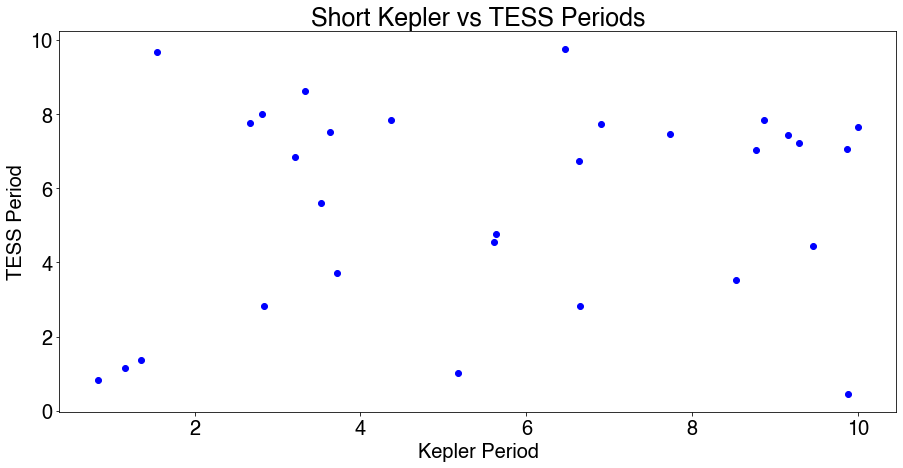

In [96]:
plt.figure(figsize=(15,7))
plt.scatter(kep_period, tess_period, c = 'blue')
plt.xlabel('Kepler Period', fontsize = 20)
plt.ylabel('TESS Period', fontsize = 20)
plt.title('Short Kepler vs TESS Periods', fontsize = 25)

In [16]:
# short kepler periods vs short tess periods
source = ColumnDataSource(data=dict(
    x =  kep_period, 
    y = tess_period, 
    tess = tics_short_periods[0:60], 
    kep = kics_short_periods[0:60]))

x2 = [i*2 for i in x]
x_half = [float(i)*0.5 for i in x]

short_kepvstess = figure(
   tools="pan,box_zoom,reset,save,hover",
   y_range=[2, 10.5], title="Short Kepler vs TESS Periods",
   x_axis_label='Kepler Period', y_axis_label='TESS Period', plot_width=900)

short_kepvstess.line(x, x, legend = "y=x", color = 'darkorange', line_dash="4 4", line_width = 2)
short_kepvstess.circle('x', 'y', source = source, color="purple", line_color=None)
short_kepvstess.line(x, x2, legend="y=2x", line_width=1, color = 'limegreen', line_dash="dotted")
short_kepvstess.line(x, x_half, legend="y=0.5*x", line_width=1, color = 'cornflowerblue', line_dash="dotted")

short_kepvstess.hover.tooltips = [
    ("index", "$index"), 
    ("(x,y)", "($x, $y)"), 
    ("TIC ID", "@tess"), 
    ("KIC ID", "@kep")] 

show(short_kepvstess)

Text(3, 10.5, 'y = 3x')

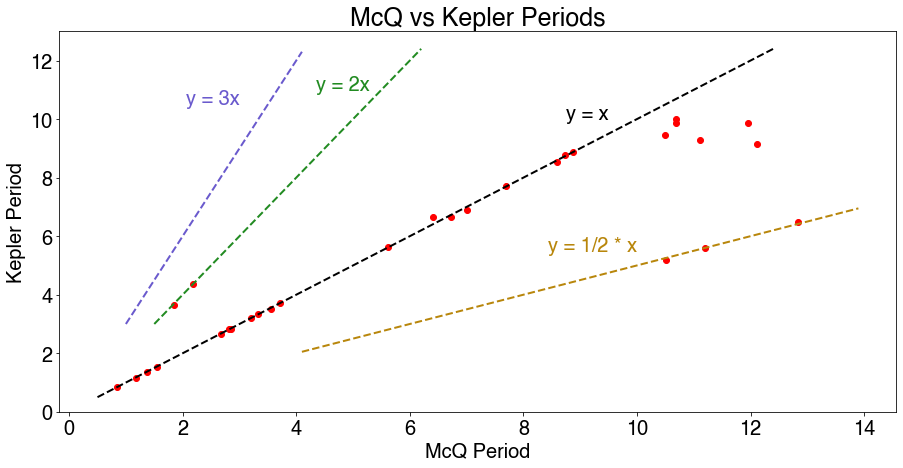

In [156]:
plt.figure(figsize=(15,7))
plt.scatter(short_periods[0:60], kep_period[0:60], c = 'red')
plt.xlabel('McQ Period', fontsize = 20)
plt.ylabel('Kepler Period', fontsize = 20)
plt.title('McQ vs Kepler Periods', fontsize = 25)
plt.ylim(0, 13)

plot_xs = np.arange(0.5, 12.5, .1)
plot_xs2 = np.arange(1.5, 6.3, .1)
plot_xs3 = np.arange(4.1, 14, .1)
plot_xs4 = np.arange(1, 4.2, .1)

plt.plot(plot_xs, 1 * plot_xs, color = 'black', linestyle = 'dashed', linewidth=2)
plt.plot(plot_xs2, 2 * plot_xs2, color = 'forestgreen',linestyle = 'dashed', linewidth=2)
plt.plot(plot_xs3, 0.5 * plot_xs3, color = 'darkgoldenrod',linestyle = 'dashed', linewidth=2)
plt.plot(plot_xs4, 3 * plot_xs4, color = 'slateblue',linestyle = 'dashed', linewidth=2)

plt.text(5.3,11,'y = 2x',horizontalalignment='right', fontsize=20, c= 'forestgreen')
plt.text(9.5,10,'y = x',horizontalalignment='right', fontsize=20, c= 'black')
plt.text(10, 5.5,'y = 1/2 * x',horizontalalignment='right', fontsize=20, c= 'darkgoldenrod')
plt.text(3, 10.5, 'y = 3x',horizontalalignment='right', fontsize=20, c= 'slateblue')

In [17]:
source = ColumnDataSource(data=dict(
    x =  short_periods[0:60],
    y = kep_period[0:60],
    tess = tics_short_periods[0:60], 
    kep = kics_short_periods[0:60]))

x2 = [i*2 for i in x]
x_half = [float(i)*0.5 for i in x]

short_kepvsmcq = figure(
   tools="pan,box_zoom,reset,save,hover",
   y_range=[0, 10.5], title="Short McQ vs Calculated Kepler Periods",
   x_axis_label='McQuillan Period', y_axis_label='Kepler Period', plot_width=900)

short_kepvsmcq.line(x, x, legend = "y=x", color = 'lightblue', line_dash="4 4", line_width = 2)
short_kepvsmcq.circle('x', 'y', source = source, color="hotpink", line_color=None)
short_kepvsmcq.line(x, x2, legend="y=2x", line_width=1, color = 'cyan', line_dash="dotted")
short_kepvsmcq.line(x, x_half, legend="y=0.5*x", line_width=1, color = 'lawngreen', line_dash="dotted")

short_kepvsmcq.hover.tooltips = [
    ("index", "$index"), 
    ("(x,y)", "($x, $y)"), 
    ("TIC ID", "@tess"), 
    ("KIC ID", "@kep")] 

show(short_kepvsmcq)

In [ ]:
# differences between calculated kepler period and mcquillian 
plt.figure(figsize=(15,7))
plt.scatter(short_periods[0:30], differences_kep, c = 'purple')
plt.xlabel('McQ Period', fontsize = 20)
plt.ylabel('Difference', fontsize = 20)
plt.title('Differences between McQ and Kepler Periods', fontsize = 25)
plt.ylim(-1,12)

(-1, 12.5)

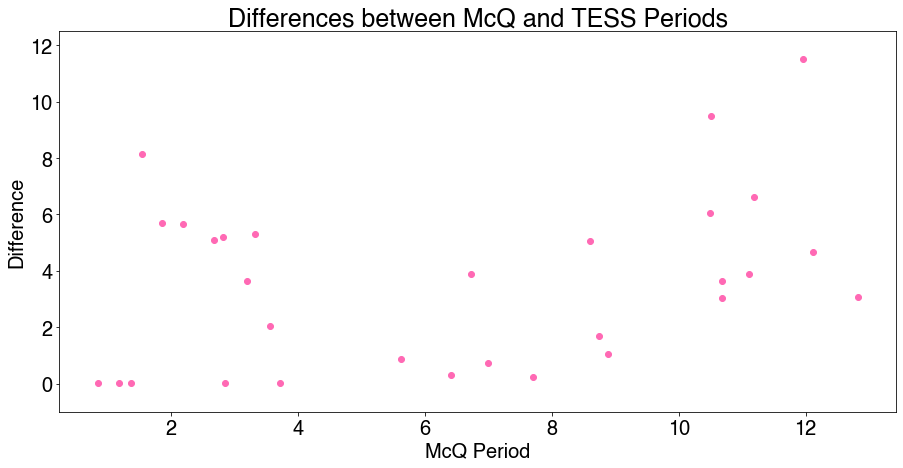

In [23]:
plt.figure(figsize=(15,7))
plt.scatter(short_periods[0:60], differences_tess, c = 'hotpink')
plt.xlabel('McQ Period', fontsize = 20)
plt.ylabel('Difference', fontsize = 20)
plt.title('Differences between McQ and TESS Periods', fontsize = 25)
plt.ylim(-1,12.5)

In [1]:
len(differences_tess)

NameError: name 'differences_tess' is not defined

In [18]:
#mcq vs tess
source = ColumnDataSource(data=dict(
    x =  short_periods[0:60],
    y = tess_period[0:60],
    tess = tics_short_periods[0:60], 
    kep = kics_short_periods[0:60]))

x2 = [i*2 for i in x]
x_half = [float(i)*0.5 for i in x]

short_tessvsmcq = figure(
   tools="pan,box_zoom,reset,save,hover",
   y_range=[0, 10.5], title="Short McQ vs Calculated TESS Periods",
   x_axis_label='McQuillan Period', y_axis_label='TESS Period', plot_width=900)

short_tessvsmcq.line(x, x, legend = "y=x", color = 'thistle', line_dash="4 4", line_width = 2)
short_tessvsmcq.circle('x', 'y', source = source, color="darkslategrey", line_color=None)
short_tessvsmcq.line(x, x2, legend="y=2x", line_width=1, color = 'chocolate', line_dash="dotted")
short_tessvsmcq.line(x, x_half, legend="y=0.5*x", line_width=1, color = 'olivedrab', line_dash="dotted")

short_tessvsmcq.hover.tooltips = [
    ("index", "$index"), 
    ("(x,y)", "($x, $y)"), 
    ("TIC ID", "@tess"), 
    ("KIC ID", "@kep")] 

show(short_tessvsmcq)

# differences between mcquillan and calculated tess periods

plt.figure(figsize=(15,7))
plt.scatter(short_periods[0:30], tess_period[0:30], c = 'hotpink')
plt.xlabel('McQ Period', fontsize = 20)
plt.ylabel('Difference', fontsize = 20)
plt.title('Difference in McQ vs TESS Periods', fontsize = 25)
plt.ylim(-1,12.5)

plot_x = np.arange(0.1, 11.5, .1)
plot_x2 = np.arange(0.1, 6, .1)
plot_x3 = np.arange(0.1, 13, .1)
plot_x4 = np.arange(0.1, 4, .1)

plt.plot(plot_x, 1 * plot_x, color = 'paleturquoise', linestyle = 'dashed', linewidth=2)
plt.plot(plot_x2, 2 * plot_x2, color = 'grey',linestyle = 'dashed', linewidth=2)
plt.plot(plot_x3, 0.5 * plot_x3, color = 'cornflowerblue',linestyle = 'dashed', linewidth=2)
plt.plot(plot_x4, 3 * plot_x4, color = 'gold',linestyle = 'dashed', linewidth=2)

plt.text(9.5,10,'y = x',horizontalalignment='right', fontsize=20, c= 'paleturquoise')
plt.text(5.3,11,'y = 2x',horizontalalignment='right', fontsize=20, c= 'grey')
plt.text(10, 5.5,'y = 1/2 * x',horizontalalignment='right', fontsize=20, c= 'cornflowerblue')
plt.text(3, 10,'y = 3x',horizontalalignment='right', fontsize=20, c= 'gold')

# acf periods

No eleanor postcard has been made for your target (yet). Using TessCut instead.



100%|██████████| 1197/1197 [00:25<00:00, 47.23it/s]


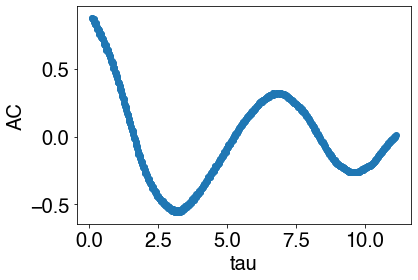

No eleanor postcard has been made for your target (yet). Using TessCut instead.



100%|██████████| 1241/1241 [00:23<00:00, 52.88it/s]


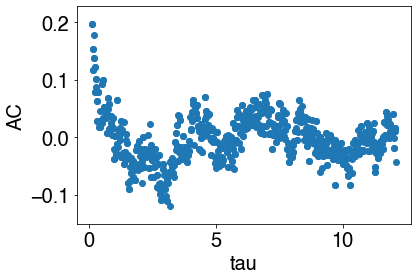

No eleanor postcard has been made for your target (yet). Using TessCut instead.



100%|██████████| 1241/1241 [00:38<00:00, 32.65it/s]


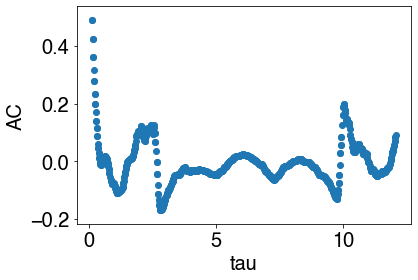

No eleanor postcard has been made for your target (yet). Using TessCut instead.



100%|██████████| 1241/1241 [00:28<00:00, 44.07it/s]


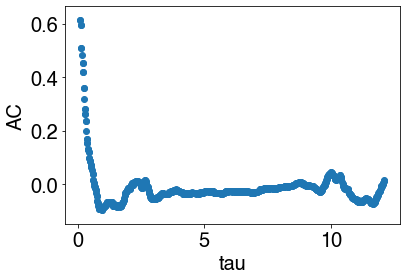

No eleanor postcard has been made for your target (yet). Using TessCut instead.



100%|██████████| 1241/1241 [00:37<00:00, 33.12it/s]


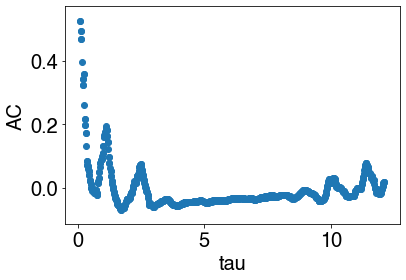

No eleanor postcard has been made for your target (yet). Using TessCut instead.



100%|██████████| 1241/1241 [00:27<00:00, 45.49it/s]


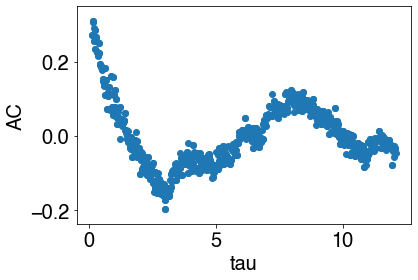

No eleanor postcard has been made for your target (yet). Using TessCut instead.



100%|██████████| 1241/1241 [00:29<00:00, 41.68it/s]


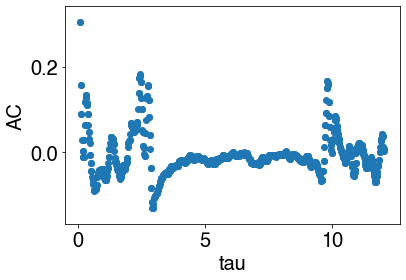

No eleanor postcard has been made for your target (yet). Using TessCut instead.



100%|██████████| 1197/1197 [00:24<00:00, 48.34it/s]


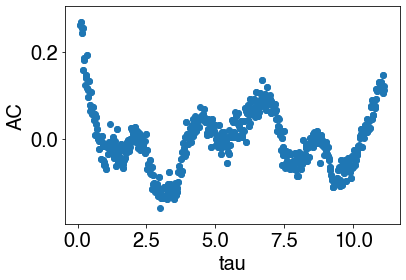

No eleanor postcard has been made for your target (yet). Using TessCut instead.



100%|██████████| 1197/1197 [00:28<00:00, 42.03it/s]


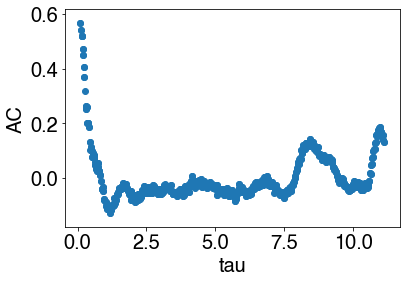

No eleanor postcard has been made for your target (yet). Using TessCut instead.



100%|██████████| 1197/1197 [00:26<00:00, 44.64it/s]


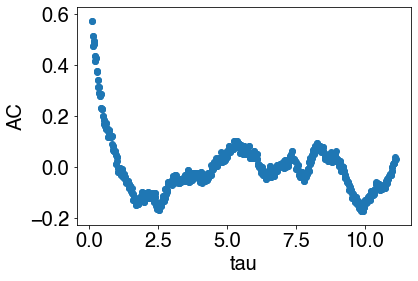

In [165]:
tess_acf = []
kep_acf = []

for index, value in (enumerate(tics_short_periods[0:10])):
    #TESS AC 
    eleanor_ac = ac_mq_tic_el(value, 1000)

    plt.scatter(eleanor_ac[1], eleanor_ac[0])
    plt.xlabel('tau', fontsize = 20)
    plt.ylabel('AC', fontsize = 20)
    plt.show()
    plt.close()

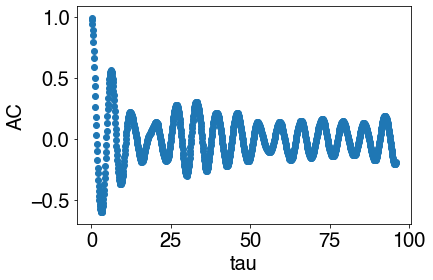

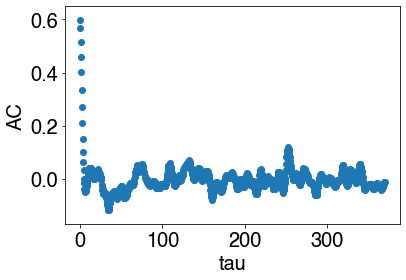

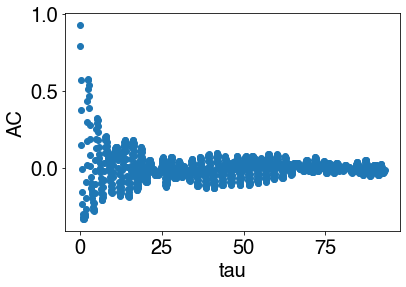

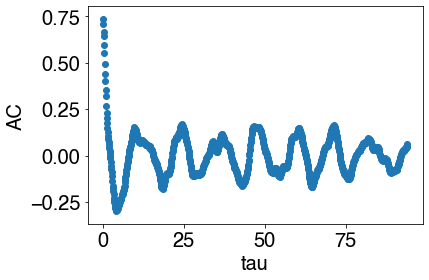

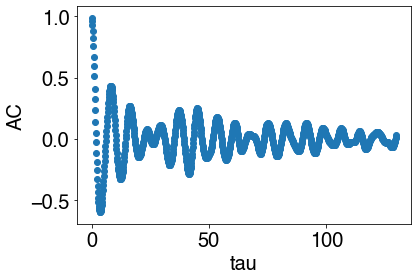

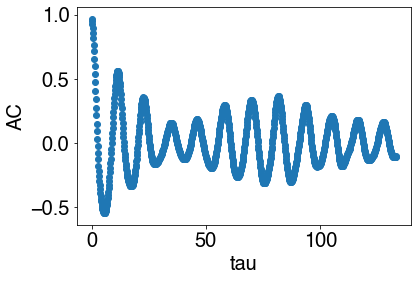

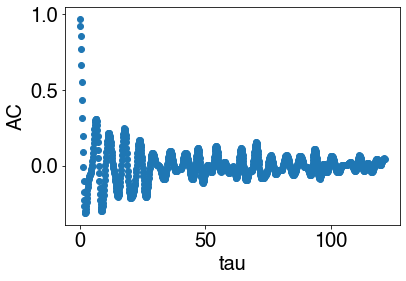

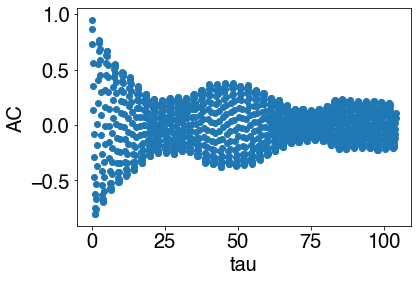

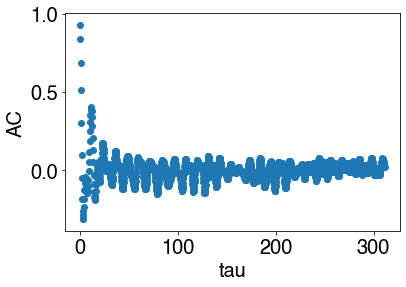

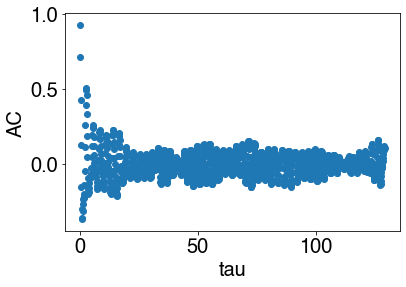

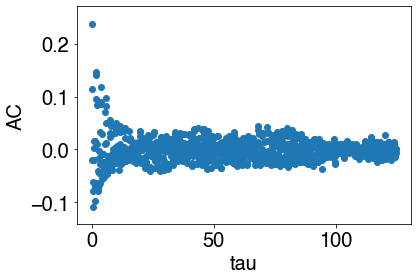

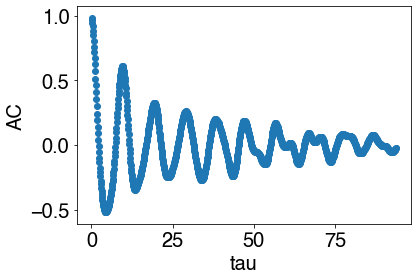

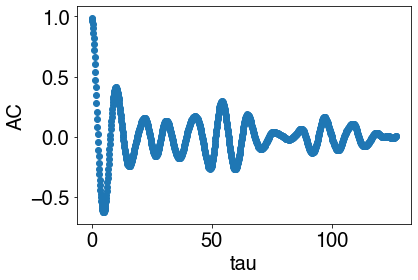

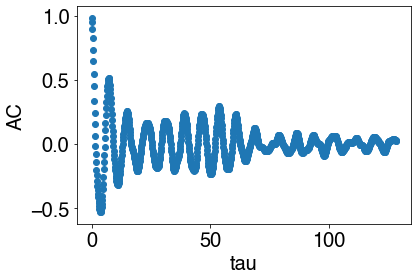

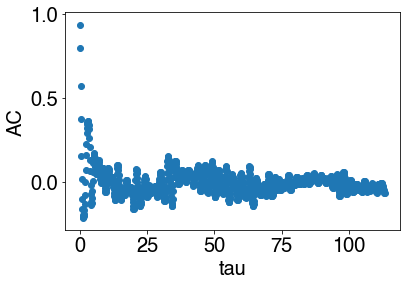

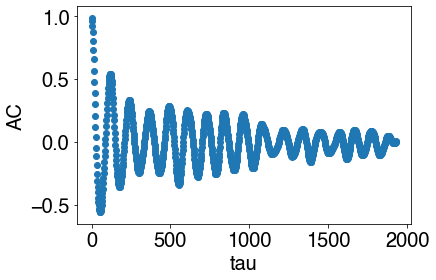

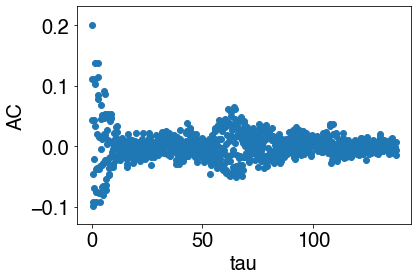

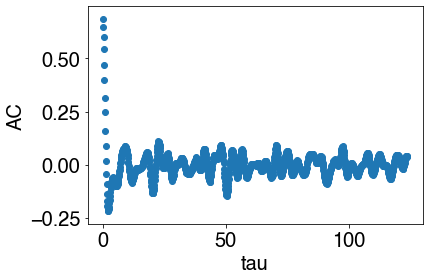

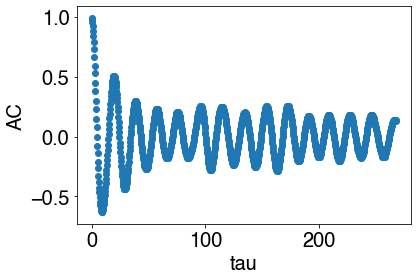

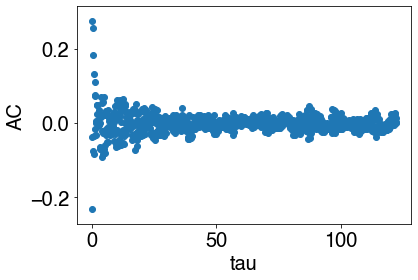

In [166]:
for index, value in (enumerate(kics_short_periods[0:20])):
    #Kepler AC 
    acf_kep = ac_mq_Q1_Q4_PDC(value, 1000);
    plt.scatter(acf_kep[1], acf_kep[0])
    plt.xlabel('tau', fontsize = 20)
    plt.ylabel('AC', fontsize = 20)
    plt.show()
    plt.close()

In [19]:
acf_tess_estimates = [7.5, 2.5, 2.5, 0.8, 1.25, 8.5, 3, 2.5, 1.25, 5]
acf_kep_estimates = [6.2, 12.5, 2.7, 12.5, 7.5, 11, 5.5, 2.7, 12.5, 2.7, 2, 10, 9.5, 8.3, 2.5, 111, 2, 6, 20, 1.5] 

In [20]:
acf_kep_diff = []
acf_tess_diff = []

for each, per in enumerate(short_periods[0:10]):
    kepdiff = np.abs(per - acf_kep_estimates[each])
    tessdiff = np.abs(per - acf_tess_estimates[each])
    
    acf_kep_diff.append(kepdiff)
    acf_tess_diff.append(tessdiff)

Text(0.5, 1.0, 'Kepler ACF vs TESS ACF Periods')

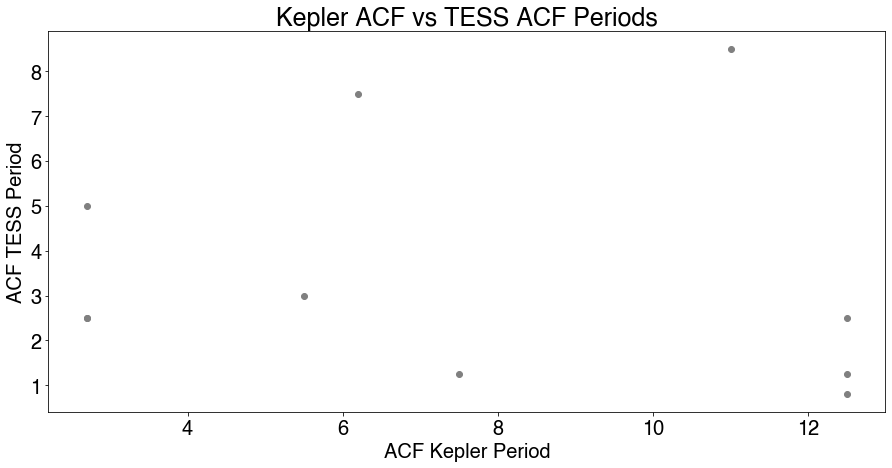

In [22]:
plt.figure(figsize=(15,7))
plt.scatter(acf_kep_estimates[0:10],acf_tess_estimates, c = 'grey')
plt.xlabel('ACF Kepler Period', fontsize = 20)
plt.ylabel('ACF TESS Period', fontsize = 20)
plt.title('Kepler ACF vs TESS ACF Periods', fontsize = 25)

Text(0.5, 1.0, 'Kepler ACF vs McQ Periods')

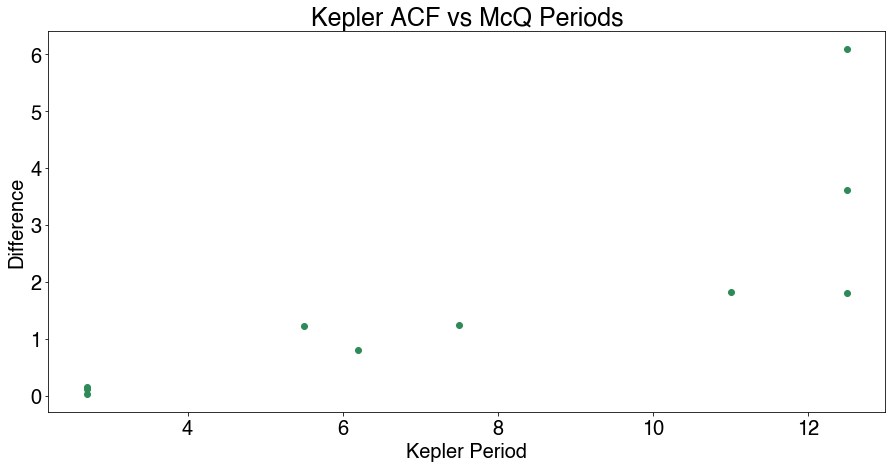

In [24]:
plt.figure(figsize=(15,7))
plt.scatter(acf_kep_estimates[0:10], acf_kep_diff, c = 'seagreen')
plt.xlabel('Kepler Period', fontsize = 20)
plt.ylabel('Difference', fontsize = 20)
plt.title('Kepler ACF vs McQ Periods', fontsize = 25)

Text(0.5, 1.0, 'TESS ACF vs McQ Periods')

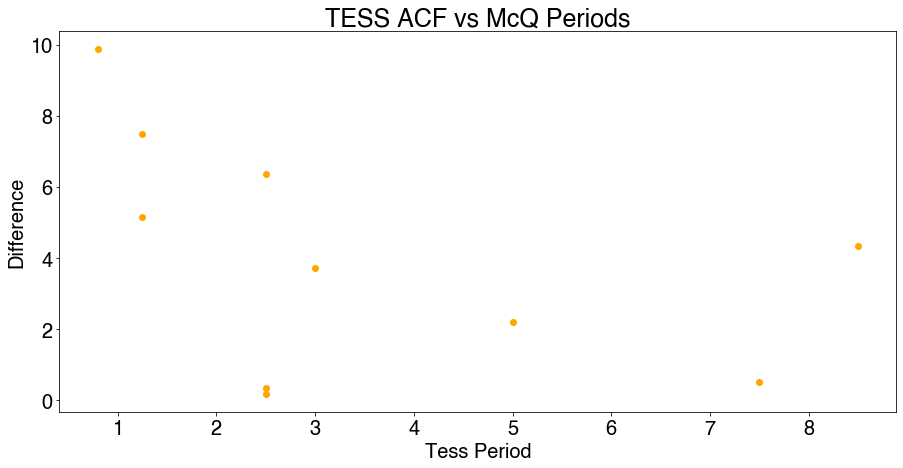

In [25]:
plt.figure(figsize=(15,7))
plt.scatter(acf_tess_estimates, acf_tess_diff, c = 'orange')
plt.xlabel('Tess Period', fontsize = 20)
plt.ylabel('Difference', fontsize = 20)
plt.title('TESS ACF vs McQ Periods', fontsize = 25)

In [26]:
ss_acf_2 = [] 
tess_cadence = 1./24./30.

for index, value in (enumerate(kics_short_periods[0:60])):
    lcf = lk.search_lightcurvefile('KIC' + str(value)).download_all()    
    figure_kep = combining_PDC_quarters(value)
    flux_kep_PDC = figure_kep[0]
    time_kep_PDC = figure_kep[1]
    flux_error_kep_PDC = figure_kep[2]
    
    rotate = ss.RotationModel(time_kep_PDC, flux_kep_PDC, flux_error_kep_PDC)
    acf_period = rotate.acf_rotation(tess_cadence)
    
    ss_acf_2.append(acf_period)

In [28]:
acf_ss_diff = []
kep_acf_est = [6.2, 12.5, 2.7, 12.5, 7.5, 11, 5.5, 2.7, 12.5, 2.7, 2, 10, 9.5, 8.3, 2.5, 111, 2, 6, 20, 1.5]

for each, per in enumerate(ss_acf_2):
    kep_diff = np.abs(per - kep_acf_est[each])
    acf_ss_diff.append(kep_diff)

Text(50, 5, 'y = 0.01 * x')

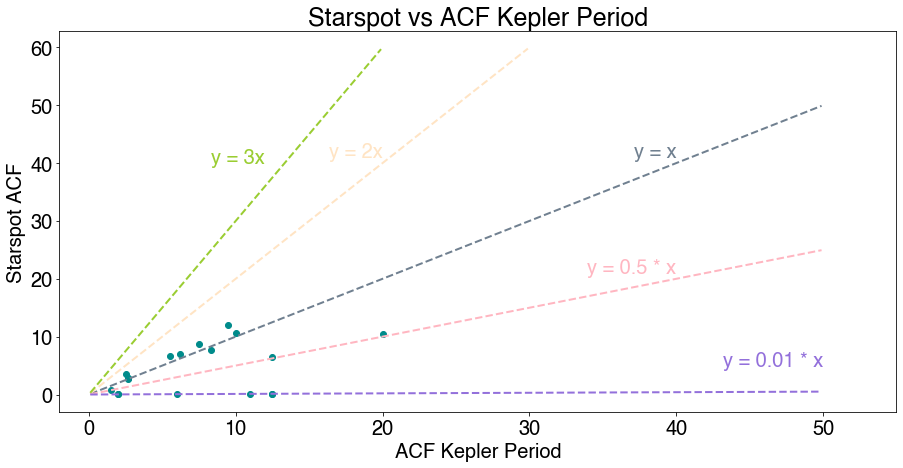

In [32]:
plt.figure(figsize=(15,7))
plt.scatter(kep_acf_est, ss_acf_2, c = 'darkcyan')
plt.xlabel('ACF Kepler Period', fontsize = 20)
plt.ylabel('Starspot ACF', fontsize = 20)
plt.title('Starspot vs ACF Kepler Period', fontsize = 25)
plt.xlim(-2, 55)

plot_x = np.arange(0.1, 50, .1)
plot_x2 = np.arange(0.1, 30, .1)
plot_x3 = np.arange(0.1, 50, .1)
plot_x4 = np.arange(0.1, 20, .1)
plot_x5 = np.arange(0.1, 50, .1)

plt.plot(plot_x, 1 * plot_x, color = 'slategrey', linestyle = 'dashed', linewidth=2)
plt.plot(plot_x2, 2 * plot_x2, color = 'bisque',linestyle = 'dashed', linewidth=2)
plt.plot(plot_x3, 0.5 * plot_x3, color = 'lightpink',linestyle = 'dashed', linewidth=2)
plt.plot(plot_x4, 3 * plot_x4, color = 'yellowgreen',linestyle = 'dashed', linewidth=2)
plt.plot(plot_x5, 0.01 * plot_x5, color = 'mediumpurple',linestyle = 'dashed', linewidth=2)

plt.text(40,41,'y = x',horizontalalignment='right', fontsize=20, c= 'slategrey')
plt.text(20,41,'y = 2x',horizontalalignment='right', fontsize=20, c= 'bisque')
plt.text(40, 21,'y = 0.5 * x',horizontalalignment='right', fontsize=20, c= 'lightpink')
plt.text(12, 40,'y = 3x',horizontalalignment='right', fontsize=20, c= 'yellowgreen')
plt.text(50, 5,'y = 0.01 * x',horizontalalignment='right', fontsize=20, c= 'mediumpurple')

In [43]:
#mcq vs ss
source = ColumnDataSource(data=dict(
    x =  kep_acf_est,
    y = ss_acf_2,
    tess = tics_short_periods[0:60], 
    kep = kics_short_periods[0:60]))

x2 = [i*2 for i in x]
x_half = [float(i)*0.5 for i in x]
x_tenth = [float(i)*0.01 for i in x]

ssvsmcq = figure(
   tools="pan,box_zoom,reset,save,hover",
   y_range=[-1, 13], x_range = [-1,25], title="Homemade ACF vs Starspot",
   x_axis_label='ACF Period', y_axis_label='Starspot Period', plot_width=900)

ssvsmcq.line(x, x, legend = "y=x", color = 'plum', line_dash="4 4", line_width = 2)
ssvsmcq.circle('x', 'y', source = source, color="seagreen", line_color=None)
ssvsmcq.line(x, x2, legend="y=2x", line_width=1, color = 'wheat', line_dash="dotted")
ssvsmcq.line(x, x_half, legend="y=0.5*x", line_width=1, color = 'salmon', line_dash="dotted")
ssvsmcq.line(x, x_tenth, legend="y=0.01*x", line_width=1, color = 'grey', line_dash="dotted")

ssvsmcq.hover.tooltips = [
    ("index", "$index"), 
    ("(x,y)", "($x, $y)"), 
    ("TIC ID", "@tess"), 
    ("KIC ID", "@kep")] 

show(ssvsmcq)

In [49]:
ss_acf_2[1]

0.0861111111111111

(-1, 15)

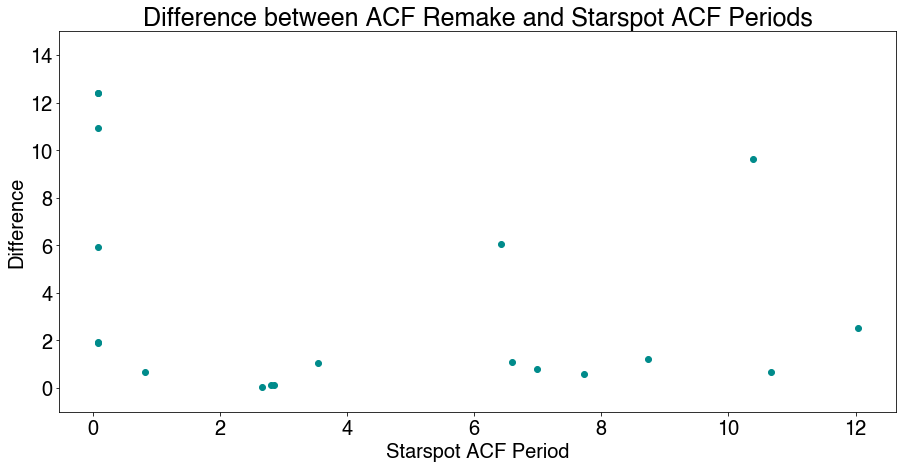

In [41]:
plt.figure(figsize=(15,7))
plt.scatter(ss_acf_2, acf_ss_diff, c = 'darkcyan')
plt.xlabel('Starspot ACF Period', fontsize = 20)
plt.ylabel('Difference', fontsize = 20)
plt.title('Difference between ACF Remake and Starspot ACF Periods', fontsize = 25)
plt.ylim(-1,15)